# Binary classification on a HEP dataset

In the tutorial we'll set aside the fundamentals and focus on the practical stuff: how to train a deep neural network on a HEP dataset.
Our problem will still be binary classification, which is simple but surprisingly subtle.
Entire working groups within experimental collaborations are dedicated to just this task.

The dataset is from collider physics, but the methods and typical problems you might encounter should carry over to other types of data, e.g. from neutrino experiments.

We'll use pytorch again. If you plan to use tensorflow or JAX for your own work, translate the notebook as an exercise!

Outline:
- Load data from root files
- Explore the data and weights
- Preprocess data for training
- How to use GPU resources
- Train / test / val splits
- Train a neural network
- Quantify its performance
- Tune the model and overtraining

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import uproot
import tqdm

import torch
from torch import nn
import torchinfo

In [2]:
# We'll use GPU acceleration in this tutorial. Let's check if we have one available.
print(f"Is CUDA available? {torch.cuda.is_available()}")
print(f"Number of GPUs available: {torch.cuda.device_count()}")

Is CUDA available? True
Number of GPUs available: 1


In [3]:
# You can change the "0" here to 1, 2, or 3 to use other GPUs on the node for the rest of the notebook
dnumber = 0
device = torch.device(f"cuda:{dnumber}" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
device_name = torch.cuda.get_device_name(dnumber)
print(f"Device name: {device_name}")

Using device: cuda:0
Device name: NVIDIA A100-PCIE-40GB


## Load data

This data set was produced from the ATLAS open data 2020 release:

https://opendata.atlas.cern/docs/category/13-tev-2020-release

The dataset contains MC simulations of the following processes that occur within LHC collisions:

- Higgs boson production, where the Higgs decays to a pair of W boson that then decay leptonically: $H \rightarrow WW \rightarrow l \nu l \nu$. We want to isolate this signal so we can study this Higgs boson.
- Other standard model processes: top-quark-pair production, single-top production, electroweak boson production in association with jets (W+jets, Z+jets), and diboson production (WW, WZ, ZZ). All of these processes can also result in final states with two leptons and significant missing transverse momentum, making them backgrounds. We want to remove these backgrounds.

The binary classification task will be to discriminate signal ($H \rightarrow WW$) from background (all of the other SM processes).
Our data will be a list of kinematic features that characterize each event.
These features should be somewhat different between the signal and background in non-trivial ways, and our classifier will use these differences to separate the two classes.

All the data are stored in a root file, which contains different kinematic variables of each event, the event label (`label`) to indicate whether an event is a signal or background, as well as the MC event weights (`mcWeight`). We use [uproot](https://uproot.readthedocs.io/en/latest/) to read data from the root file.
Given the prevalence of root files in HEP, and the prevalence of Python in machine learning, uproot is an indispensible tool for applications of ML in HEP.
Learn to use it!

In [4]:
filename = "dataWW_d1.root"
file = uproot.open(filename)

# show what is inside the root file loaded from uproot
print(file.classnames())

tree = file["tree_event"]  # select the TTree inside the root file
tree.show()  # show all the branches inside the TTree
dfall = tree.arrays(library="pd")  # convert uproot TTree into pandas dataframe
print("============================================")
print("File loaded with ", len(dfall), " events ")

{'tree_event;1': 'TTree'}
name                 | typename                 | interpretation                
---------------------+--------------------------+-------------------------------
index                | int64_t                  | AsDtype('>i8')
eventNumber          | int64_t                  | AsDtype('>i8')
label                | int64_t                  | AsDtype('>i8')
met_et               | double                   | AsDtype('>f8')
met_phi              | double                   | AsDtype('>f8')
lep_n                | int64_t                  | AsDtype('>i8')
lep_pt_0             | double                   | AsDtype('>f8')
lep_pt_1             | double                   | AsDtype('>f8')
lep_eta_0            | double                   | AsDtype('>f8')
lep_eta_1            | double                   | AsDtype('>f8')
lep_phi_0            | double                   | AsDtype('>f8')
lep_phi_1            | double                   | AsDtype('>f8')
lep_E_0              | double   

In [5]:
# dump list of feature
dfall.columns

Index(['index', 'eventNumber', 'label', 'met_et', 'met_phi', 'lep_n',
       'lep_pt_0', 'lep_pt_1', 'lep_eta_0', 'lep_eta_1', 'lep_phi_0',
       'lep_phi_1', 'lep_E_0', 'lep_E_1', 'lep_charge_0', 'lep_charge_1',
       'lep_type_0', 'lep_type_1', 'jet_n', 'jet_pt_0', 'jet_pt_1',
       'jet_eta_0', 'jet_eta_1', 'jet_phi_0', 'jet_phi_1', 'jet_E_0',
       'jet_E_1', 'mcWeight', 'runNumber', 'channelNumber'],
      dtype='object')

In [6]:
# examine first few events
dfall.head()

,index,eventNumber,label,met_et,met_phi,lep_n,lep_pt_0,lep_pt_1,lep_eta_0,lep_eta_1,...,jet_pt_1,jet_eta_0,jet_eta_1,jet_phi_0,jet_phi_1,jet_E_0,jet_E_1,mcWeight,runNumber,channelNumber
0,0,249632,1,25.118,1.14010,2,46.439,44.589,0.131030,0.40654,...,-7.000,2.4346,-7.00000,-0.76667,-7.00000,308720.0,-7.0,0.000002,284500,345323
1,1,892975,1,27.974,0.84442,2,86.819,55.438,-0.017265,-0.16338,...,-7.000,-1.2789,-7.00000,1.66290,-7.00000,245670.0,-7.0,0.000002,284500,345323
2,2,730573,0,123.290,-2.94810,2,105.810,40.506,-1.338900,-1.03500,...,-7.000,-7.0000,-7.00000,-7.00000,-7.00000,-7.0,-7.0,0.002468,284500,363492
3,3,717584,0,78.558,1.04450,2,56.666,35.124,2.294600,1.88700,...,53.942,1.6270,0.55314,-1.84880,-0.47055,211610.0,63629.0,0.000197,284500,363492
4,4,319020,0,15.863,0.74840,2,94.708,72.811,0.812740,0.77954,...,-7.000,-0.6358,-7.00000,-1.91230,-7.00000,173810.0,-7.0,0.000197,284500,363492


We have 800k events in this data file, which sits in a nice medium range where we have plenty of data for training but not so much data that we will run into memory constraints.
What to do in cases when this is not true is beyond the scope for today, but keep in mind it didn't need to be this way, and often won't be in real world applications.

## Event selection

In this example, we want to focus on events with exactly 2 leptons (electrons or muons).
There are both signal and background events where this will not be the case, e.g. if a lepton is missed by the detector, but this is a small effect that we can ignore for today.

In [7]:
print("Number of events before selections:", len(dfall))
fulldata = dfall[dfall.lep_n == 2]
print("Number of events after selections:", len(fulldata))

Number of events before selections: 600000
Number of events after selections: 596571


In collider physics, a common feature of simulated datasets is event weights.
These weights arise from the beyond leading order Feynman diagram calculations that occur within event generators.
Without the weights, the simulation will not resemble real data with as much accuracy.
If you're a collider physicist, you're probably already familiar with these weights.
If not, you can ignore this detail and just continue on in the notebook.
As you'll see, what we'll have to do to handle these weights is actually quite minimal

Let's load the weights, stored in the column `mcWeight` and the labels, stored in the column `target`. Like in this morning's tutorial, the labels will take on a value of 1.0 for signal and 0.0 for background

Number of selected signal events: 397728
Number of selected background events: 198843


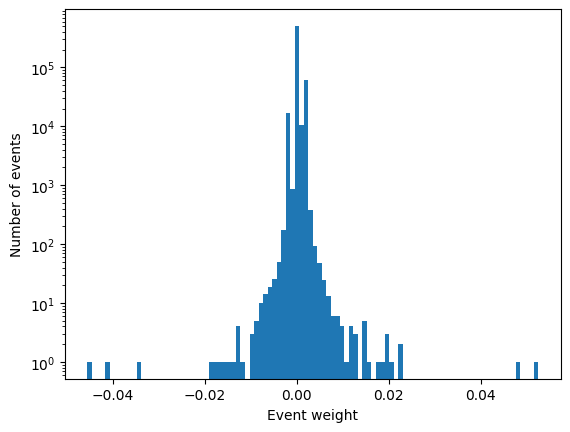

Mean weight: 0.00021820649947751399
Std weight: 0.0007363346766555201
Max weight: 0.05242
Min weight: -0.045557


In [8]:
target = np.array(fulldata.label)
weights = np.array(fulldata.mcWeight)

print("Number of selected signal events:", len(fulldata[target == 1]))
print("Number of selected background events:", len(fulldata[target == 0]))

# plot the distribution of the weights
plt.hist(weights, bins=100, log=True)
plt.xlabel("Event weight")
plt.ylabel("Number of events")
plt.show()

print(f"Mean weight: {weights.mean()}")
print(f"Std weight: {weights.std()}")
print(f"Max weight: {weights.max()}")
print(f"Min weight: {weights.min()}")

For the collider physicists: a few things to note about this weight distribution. First, the mean weight is very small, only about 0.0002. This reduces the effective number of events in our data sample, but as we'll see it doesn't actually matter for training the network. Second, some of these weights are negative. This may seem like a problem, and many data science tools will break if asked to work with some negative event weights, but in reality we can train networks with a small fraction of negative weights with no issue, as we'll do so here!

Next we need to decide which features we'll use to disciminate the signal from background. Tho start we'll just use 6 features, but one of the great things about machine learning based classifiers, like neural networks or BDTs, is they can easily accommodate and will benefit from more features, assuming those features are pre-processed properly. These extra features can be either orthogonal features that tell the network something new about the events, or "engineered" features which we know, perhaps from thinking about the underlying physics, are useful.

In [9]:
data = pd.DataFrame(fulldata, columns=["met_et", "met_phi", "lep_pt_0", "lep_pt_1", 'lep_eta_0', 'lep_eta_1'])

# Or we can use more features to improve the discrimination power:
# data=pd.DataFrame(fulldata, columns=["met_et","met_phi","lep_pt_0","lep_pt_1",'lep_eta_0', 'lep_eta_1',
#                                      'lep_phi_0', 'lep_phi_1','jet_n','jet_pt_0',
#                                      'jet_pt_1', 'jet_eta_0', 'jet_eta_1', 'jet_phi_0', 'jet_phi_1'])

# We can also engineer our own feature:
# data["lep_deltaphi"]=np.abs(np.mod(data.lep_phi_1-data.lep_phi_0+3*np.pi,2*np.pi)-np.pi)

data.head()

,met_et,met_phi,lep_pt_0,lep_pt_1,lep_eta_0,lep_eta_1
0,25.118,1.14010,46.439,44.589,0.131030,0.40654
1,27.974,0.84442,86.819,55.438,-0.017265,-0.16338
2,123.290,-2.94810,105.810,40.506,-1.338900,-1.03500
3,78.558,1.04450,56.666,35.124,2.294600,1.88700
4,15.863,0.74840,94.708,72.811,0.812740,0.77954


<Figure size 640x480 with 0 Axes>

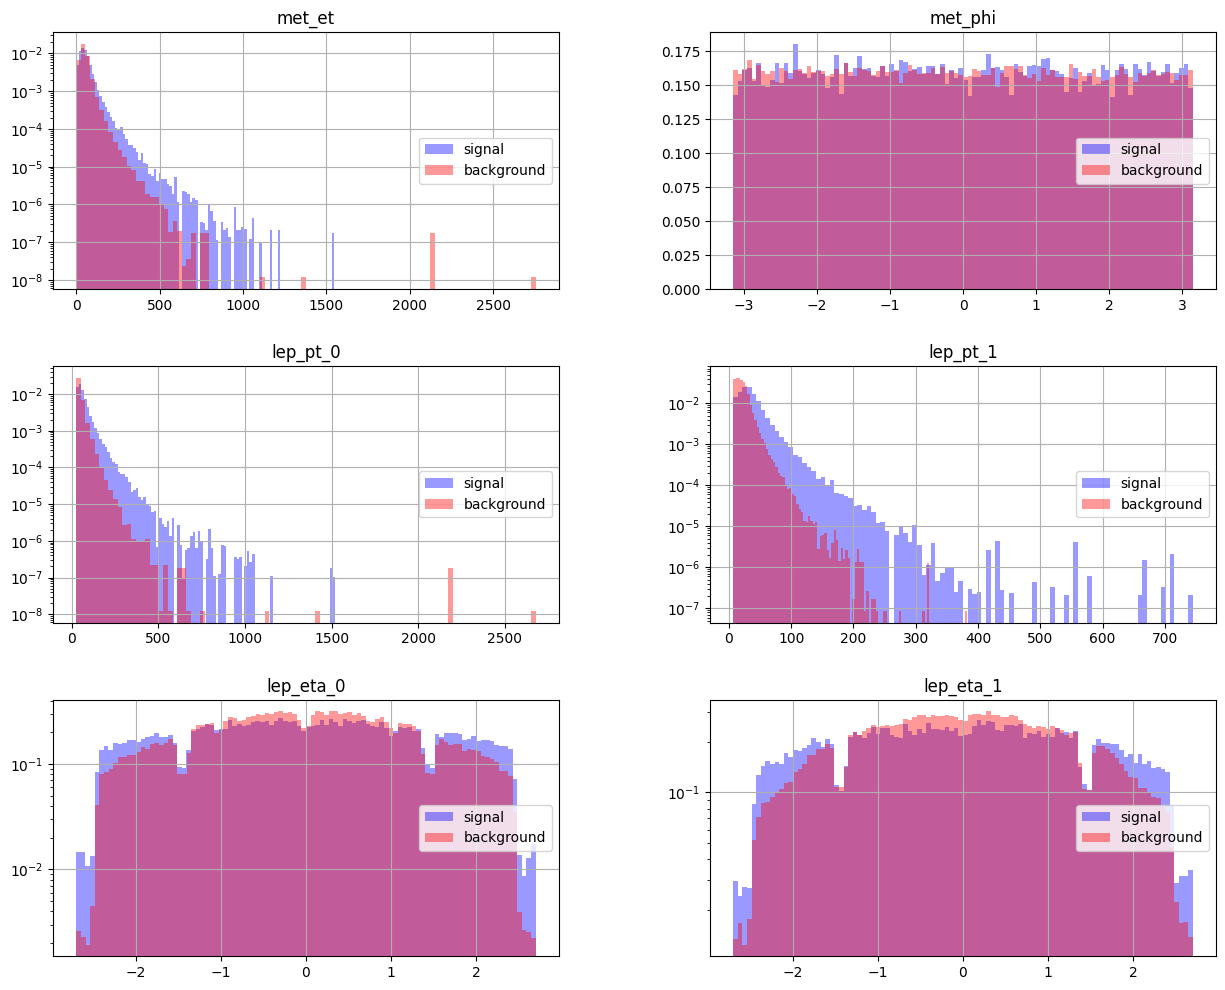

In [10]:
plt.figure()
ax = data[target == 0].hist(
    weights=weights[target == 0], figsize=(15, 12), color='b', alpha=0.4, density=True, label="signal", bins=100
)
ax = ax.flatten()[: data.shape[1]]  # to avoid error if holes in the grid of plots (like if 7 or 8 features)
data[target == 1].hist(
    weights=weights[target == 1], figsize=(15, 12), color='r', alpha=0.4, density=True, ax=ax, label="background", bins=100
)
for i in range(len(ax)):
    ax[i].legend(loc='right')
    if not "phi" in data.keys()[i]:
        ax[i].set_yscale("log")
plt.show()

What are these features?

- `met_et` is the missing transverse momentum in the event in units of GeV. We expect to see a large amount of missing transverse momentum in the signal class, because of the two neutrinos in the final state.
- `lep_pt_0` and `lep_pt_1` are the transverse momentum of the leading (higher $p_T$) and sub-leading (lower $p_T$) leptons in units of GeV.
- `met_phi` is the azimuthal angle of the missing transverse momentum vector
- `lep_eta_0` and `lep_eta_1` are the pseudorapidity of the leading and sub-leading leptons, respectively

If you're unfamiliar with these coordinates, see the Figure below (pseudorapidity is denoted $\eta$).
Note the azimuthal angle observable offers no separation between signal and background, as we could expect from symmetry arguments.
You can get rid of it from what follows and expect no differences in performance, but we can also include it and see no drop in performance.
In general, neural networks and BDT based binary classifiers are very good at ignoring irrelevant features in most applications.
There's generally no risk to adding extra features as input.
If you're tring to maximize performance, the best advice is to use everything!

<img src="axis3D_CMS-005.png" alt="drawing" width="700"/>

## Data preprocessing

The scale of the inputs we will use as input to our network vary significantly.
For example the dimensionful inputs can have values up to several thousand, but the azimuthal angle and pseudorapidity inputs are bounded and symmetrically distributed about zero.
In network training, large scale inputs can have significant negative impacts, making the optimization either very difficult, or causing it to break entirely.
It's always best to make histograms of your inputs prior to training, and ensure that they have some "reasonable" distribution..

These are the 2 most common ways to rescale a given input:

1. **Scale to Mean of 0 and Variance of 1.0:**   $\ \ \ \ x^\prime = (x-\mu)/\sigma$
2. **Scale to Max of 1 and Min of 0:**   $\ \ \ \ x^\prime = (x-x_{\mathrm{min}})/(x_{\mathrm{max}}-x_{\mathrm{min}})$

In the following, we'll take the first approach. One way to do this would be to apply the scaling right now, to all of the data, and forget about it for the rest of the notebook.
However I personally dislike this approach because if you ever want to use the trained network later, you'll need to remember exactly what scaling you applied to the data.
This is a great way to introduce a hard to find bug.
Instead, I find it useful to make the rescaling a part of the network itself.
We'll do this below.
All we need to do for now is calculate the mean and std. deviation of our input observables.

In [11]:
means = np.array(data.mean(axis=0))
stds = np.array(data.std(axis=0))

print("Means:")
print(means)
print("Stds:")
print(stds)

Means:
[ 6.02780576e+01 -8.23192340e-03  6.01928220e+01  2.81181012e+01
  4.10741639e-04 -6.73525301e-04]
Stds:
[46.61779439  1.81266806 40.94265249 20.34724452  1.21066976  1.23602892]


## Adjust the Signal/Background Weights for balanced training

It's very common to encounter "unbalanced" datasets in HEP, where you might have many more background events available for training compared to the signal.
For example in our current dataset, we have double the number of background events.
To first order, this actually won't matter at all for our training.
This is because the minimum of the standard cross-entropy loss used for classification is independent of the class ratio.
In other words, we could have a dataset with a 1:1 class ratio and a 10:1 class ratio, and the weights and biases that minimize the loss function on both datasets would be the same.
However, balanced datasets have some nice statistical properties that we can utilize, and truly unbalanced datasets can produce optimization issues.
For example, if you class ratio is 1000:1 and your batch size is 256, then most batches will not contain a single signal event!
For these reasons, it's typically best to normalize the event weights to our class ratio is one.
As an added bonus, we can also normalize the total sum of the event weights across the whole training set such that the mean event weight is 1.0.
The following equations make this happen:

$$f_s = \frac{2 \sum_{i \in s} w_i}{N_s + N_b}$$
$$f_b = \frac{2 \sum_{i \in b} w_i}{N_s + N_b}$$

where we can divide the weights for the background and signal class by the factors $f_s$ and $f_b$ respectively.


In [12]:
print("Sum of signal weights before normalization:", weights[target == 1].sum())
print("Sum of background weights before normalization:", weights[target == 0].sum(), "\n")

f_s = 2 * np.sum(weights[target == 1]) / (len(weights))
f_b = 2 * np.sum(weights[target == 0]) / (len(weights))

weights[target == 1] /= f_s
weights[target == 0] /= f_b

print("Sum of signal weights after normalization:", weights[target == 1].sum())
print("Sum of background weights after normalization:", weights[target == 0].sum(), "\n")

print("Class ratio:", weights[target == 1].sum() / weights[target == 0].sum())
print("Mean event weight:", weights.mean())

Sum of signal weights before normalization: 6.166582097600001
Sum of background weights before normalization: 124.0090875022 

Sum of signal weights after normalization: 298285.5
Sum of background weights after normalization: 298285.5 

Class ratio: 1.0
Mean event weight: 0.9999999999999998


At this point we've normalized our weights, have the data and labels ready, and have a pre-processing plan that we'll implement into the network itself.
This is a good point at which to turn everything into PyTorch tensors.

In [13]:
data = torch.tensor(np.array(data), dtype=torch.float32)
target = torch.tensor(np.array(target), dtype=torch.float32)
weights = torch.tensor(np.array(weights), dtype=torch.float32)
means = torch.tensor(means, dtype=torch.float32)
stds = torch.tensor(stds, dtype=torch.float32)

print("Data shape:", data.shape)
print("Target shape:", target.shape)
print("Weights shape:", weights.shape)
print("Means shape:", means.shape)
print("Stds shape:", stds.shape)

Data shape: torch.Size([596571, 6])
Target shape: torch.Size([596571])
Weights shape: torch.Size([596571])
Means shape: torch.Size([6])
Stds shape: torch.Size([6])


This looks almost right.
The only issue is that PyTorch will expect the labels and weights to have the same number of dimensions as the data, that is 2.
We can add a "singleton" dimension using the unsqueeze function

In [14]:
target = target.unsqueeze(1)
weights = weights.unsqueeze(1)

print(f"Target shape: {target.shape}")
print(f"Weights shape: {weights.shape}")

Target shape: torch.Size([596571, 1])
Weights shape: torch.Size([596571, 1])


# How to use a GPU

We've already completed a large portion of the work needed to use GPU resources, in that PyTorch should already be recognizing the GPU resources available on your Perlmutter node (`torch.cuda.is_available()` returns True).
Getting Pytorch or Tensorflow to recognize and use GPU resources is easier than it used to be, but can still be non-trivial.
We won't spend time on it in this tutorial, but you should budget some time to get your software stack setup on whatever resources you will use outside of the school. Ask any of us if you have questions or want advice!

We've already seen that PyTorch lets us compute gradients, which is the most essential thing for ML.
Another difference between PyTorch and numpy is support for GPU operations.
All tensors are by default initialized in CPU memory, even if PyTorch detects GPU resources.
You can see what device a tensor is currently stored on using the "device" method, and you can move tensors between devices using the ".to" method:

In [15]:
m1_tensor = torch.randn(3, 4)
m2_tensor = torch.randn(4, 3)

print(f"m1 device: {m1_tensor.device}")
print(f"m2 device: {m2_tensor.device}")

# Move tensors to GPU, note operation is not in place!
m1_tensor_gpu = m1_tensor.to(device)
m2_tensor_gpu = m2_tensor.to(device)

print(f"m1 device: {m1_tensor_gpu.device}")
print(f"m2 device: {m2_tensor_gpu.device}")

m1 device: cpu
m2 device: cpu
m1 device: cuda:0
m2 device: cuda:0


That was quick for a small tensor, but in general moving large tensors between devices is not a free operation.
Unnecessarily repeating this operation is a common way to accidently bottleneck network training!
Ideally you should minimize these operations in your code (or use someone else's code that takes care of this for you).

Now that we have tensors on the GPU, let's time our matrix multiplication

In [16]:
# First the CPU
%timeit m1_tensor @ m2_tensor

1.67 μs ± 43.3 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [17]:
# Now the pytorch version
%timeit m1_tensor_gpu @ m2_tensor_gpu

9.05 μs ± 82.6 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


It's actually slower! The reason is that GPUs are fast because they parallelize operations, and our matrices are way to small to make that parallelization worthwhile. Let's go bigger

In [18]:
m1_large = torch.randn(1000, 2000)
m2_large = torch.randn(2000, 1000)

%timeit m1_large @ m2_large

3.85 ms ± 549 μs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [19]:
m1_large_gpu = m1_large.to(device)
m2_large_gpu = m2_large.to(device)

%timeit m1_large_gpu @ m2_large_gpu

262 μs ± 6.64 μs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


When testing this tutorial, I get roughly a 10x speed-up!
That's pretty good in itself, but keep in mind that CPU matrix multiplication is quite optimized. Other operations common in machine learning might enjoy even better speed-ups.

These speeds ups will transfer over to the actual training of neural networks.
However, as you can hopefully start to understand from the above, the benefits tend to matter most when training large networks on large datasets.
If you have a simple problem that be solved perfectly well using small datasets and small networks, you can get a long way with only CPU operations, even run just on your laptop!
But if you want to train something state-of-the-art, GPU resources will be required.

Before moving on to building our neural network, let's move all of the data to the GPU.
We're doing this here, before splitting the data into different pieces and training a network, to avoid having to perform the ".to" operation many times.
We can get away with this because our data set is very small.
If you have to deal with larger data sets, there is a very good chance that your data will not fit in the GPU memory all at once.
We won't cover the solutions to this issue today, but there are some links below for further reading.
For now, just don't take the fact that we can call these operations with no issues for granted!

In [20]:
data = data.to(device)
target = target.to(device)
weights = weights.to(device)

print(f"Data shape: {data.shape}")
print(f"Target shape: {target.shape}")
print(f"Weights shape: {weights.shape}")

Data shape: torch.Size([596571, 6])
Target shape: torch.Size([596571, 1])
Weights shape: torch.Size([596571, 1])


## Data splitting

It is very common in machine learning to split data into multiple independent sets, and only use part of the data for training/optimizing the machine learning models, and the rest for testing/evaluating performance. This is to check for possible over-fitting.

In the following, we will split the whole data into 50% training set, 25% validation set and 25% test set:

- __Training Dataset:__ The sample of data used to fit the model.
- __Validation Dataset:__ The sample used to provide an unbiased evaluation of a model fit on the training dataset while tuning  hyperparameters.
- __Test Dataset:__ The sample of data used to provide an unbiased evaluation of a final model fit on the training dataset.


We'll do this using the very commonly used `train_test_split` function from Scikit Learn

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

### Split the Data into training set and rest (validation + test)

In [21]:
from sklearn.model_selection import train_test_split

(
    X_train,
    X_val_and_test,
    y_train,
    y_val_and_test,
    weights_train,
    weights_val_and_test
) = train_test_split(data, target, weights, train_size=0.5)

print("X_train Shape: ", X_train.shape)
print("y_train Shape: ", y_train.shape)
print("Training Weights shape: ", weights_train.shape, "\n")
print("X_val_and_test Shape: ", X_val_and_test.shape)
print("y_val_and_test Shape: ", y_val_and_test.shape)
print("weights_val_and_test shape: ", weights_val_and_test.shape)

X_train Shape:  torch.Size([298285, 6])
y_train Shape:  torch.Size([298285, 1])
Training Weights shape:  torch.Size([298285, 1]) 

X_val_and_test Shape:  torch.Size([298286, 6])
y_val_and_test Shape:  torch.Size([298286, 1])
weights_val_and_test shape:  torch.Size([298286, 1])


### Split the rest (val + test) into validation set and test set

In [22]:
(
    X_test,
    X_val,
    y_test,
    y_val,
    weights_test,
    weights_val,
) = train_test_split(X_val_and_test, y_val_and_test, weights_val_and_test, train_size=0.5)

print("X_train Shape: ", X_train.shape)
print("y_train Shape: ", y_train.shape)
print("weights_train shape: ", weights_train.shape, "\n")
print("X_val Shape: ", X_val.shape)
print("y_val Shape: ", y_val.shape)
print("weights_val shape: ", weights_val.shape, "\n")
print("X_test Shape: ", X_test.shape)
print("y_test Shape: ", y_test.shape)
print("weights_test shape: ", weights_test.shape)

X_train Shape:  torch.Size([298285, 6])
y_train Shape:  torch.Size([298285, 1])
weights_train shape:  torch.Size([298285, 1]) 

X_val Shape:  torch.Size([149143, 6])
y_val Shape:  torch.Size([149143, 1])
weights_val shape:  torch.Size([149143, 1]) 

X_test Shape:  torch.Size([149143, 6])
y_test Shape:  torch.Size([149143, 1])
weights_test shape:  torch.Size([149143, 1])


## Building the neural network

Now for the fun bit.
We'll use Pytorch to build a simple multi-layer perceptron neural networks.
It will have two hidden layers, with 256 nodes each, interleaves with ReLU activation functions.
The last layer uses the Sigmoid activation to output a classifier score that ranges from 0 to 1.

In PyTorch, all neural networks are subclasses of the `torch.nn.Module` class.
In the `__init__` function (constructor), we'll initialize all of the network's weights and biases.
Then we need to define a forward function, which implements the forward pass through the network.
Rememeber we also want to make the input pre-processing part of the network as well.
We can do all of this in just a few lines of code.

In [23]:
class HiggsNet(torch.nn.Module):
    def __init__(self, input_dim, means, stds):
        """
        Initialize the network.
        Args:
            input_dim (int): The number of input features.
            means (torch.Tensor): The mean of the input features, shape (input_dim,).
            stds (torch.Tensor): The standard deviation of the input features, shape (input_dim,).

        Returns:
            None
        """
        super().__init__()  # This calls the parent class's constructor
        self.input_dim = input_dim

        # Here we register the means and stds as parameters, but we don't want to train them!
        # This is accomplished by setting requires_grad to False.
        self.means = nn.Parameter(means, requires_grad=False)
        self.stds = nn.Parameter(stds, requires_grad=False)

        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        """
        Forward pass through the network.
        Args:
            x (torch.Tensor): The input features, shape (batch_size, input_dim).

        Returns:
            torch.Tensor: The output of the network, shape (batch_size, 1).
        """

        # Rescale the input features to have mean 0 and std 1
        x = (x - self.means) / self.stds

        # Forward pass through the network
        return self.linear_relu_stack(x)

In [24]:
# Let's initialize the network and print the architecture using the torchinfo library
model = HiggsNet(input_dim=6, means=means, stds=stds)
torchinfo.summary(model)

Layer (type:depth-idx)                   Param #
HiggsNet                                 12
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       1,792
│    └─ReLU: 2-2                         --
│    └─Linear: 2-3                       65,792
│    └─ReLU: 2-4                         --
│    └─Linear: 2-5                       257
│    └─Sigmoid: 2-6                      --
Total params: 67,853
Trainable params: 67,841
Non-trainable params: 12

Our network has 67,853 total parameters, the vast majority of which are contained in the weights which map between the two hidden layers.
Note there are also 12 non-trainable parameters, which are the 6 means and 6 standard deviations that will scale our inputs.
Let's see if we can execute a forward pass:

In [25]:
test_input = X_train[:10,:]
print(f"Test input shape: {test_input.shape}")
test_output = model(test_input)
print(f"Test output shape: {test_output.shape}")
print(f"Test output: {test_output}")

Test input shape: torch.Size([10, 6])


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu!

This should return an error, because by default PyTorch initializes the model weights and biases on the CPU, while we have all of our data on the GPU.
The solution is a simple ".to" call.

In [26]:
model = model.to(device)
print(f"Model parameters on device: {next(model.parameters()).device}")

Model parameters on device: cuda:0


In [27]:
test_output = model(test_input)
print(f"Test output shape: {test_output.shape}")
print(f"Test output: {test_output}")

Test output shape: torch.Size([10, 1])
Test output: tensor([[0.4846],
        [0.4972],
        [0.4759],
        [0.5112],
        [0.4696],
        [0.5101],
        [0.4926],
        [0.4848],
        [0.4868],
        [0.5042]], device='cuda:0', grad_fn=<SigmoidBackward0>)


You should see that the network output on some random data points are around 0.5.
This is a good place to start for binary classification: the network is guessing equal probability of signal and background, having learned nothing yet.
If you don't see this, it's a good sign you haven't scaled your inputs well, or something else is wrong.

## Training the neural network

Before we train, it's a good idea to shuffle the training data.
The network would train fine without this step, but sometimes in HEP datasets the data can have hidden order you're not aware of.
For example, there can be multiple MC samples pasted together, and if you don't shuffle the network "sees" each one of these in sequence as it works through an epoch.
Such situations are best avoided.
We can shuffle the data using another utility function from sklearn

In [28]:
from sklearn.utils import shuffle

X_train, y_train, weights_train = shuffle(X_train, y_train, weights_train)

In [ ]:
# If we want to use a weighted loss, it's essential to set the reduction to "none"
# This way we can weight each event individually
criterion = torch.nn.BCELoss(reduction="none")

# We'll use the Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Some parameters for the training loop
n_epochs = 10
batch_size = 1024
train_losses = []
val_losses_steps = []
val_losses = []
global_step = 0  # So we can align the validation loss with the training loss

# Epoch loop
for epoch in tqdm.tqdm(range(n_epochs)):

    # Batch loop
    for i in range(0, len(X_train), batch_size):

        # Get a batch of data
        X_batch = X_train[i:i+batch_size,:]
        y_batch = y_train[i:i+batch_size]
        weights_batch = weights_train[i:i+batch_size]

        # Forward pass
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)

        # Weight the loss by the event weight, then take mean over the batch
        loss = (loss * weights_batch).mean()

        # Backward pass
        optimizer.zero_grad()  # This important line clears the gradients from the previous batch
        loss.backward()
        optimizer.step()

        # Add the loss to the training loss list
        train_losses.append(loss.item())
        global_step += 1

    # Validation step, we'll do this at the end of each epoch
    # Note I won't even both batching this step, since we have plenty of memory, but if you have a big dataset
    # you could do this in batches as well.
    with torch.no_grad():
        outputs = model(X_val)
        loss = criterion(outputs, y_val)

        # Weight the loss by the event weight, then take mean over the whole validation set
        loss = (loss * weights_val).mean()

        val_losses_steps.append(global_step)
        val_losses.append(loss.item())

    # As a final step, shuffle the training data again to prepare for the next epoch
    X_train, y_train, weights_train = shuffle(X_train, y_train, weights_train)

 10%|█         | 1/10 [00:00<00:04,  2.16it/s]

End of epoch 0
Training Loss: 0.6359535455703735
Validation Loss: 0.47357937693595886


 20%|██        | 2/10 [00:00<00:03,  2.61it/s]

End of epoch 1
Training Loss: 0.41188034415245056
Validation Loss: 0.46457239985466003


 30%|███       | 3/10 [00:01<00:02,  2.81it/s]

End of epoch 2
Training Loss: 0.32398855686187744
Validation Loss: 0.46351301670074463


 40%|████      | 4/10 [00:01<00:02,  2.98it/s]

End of epoch 3
Training Loss: 0.41288888454437256
Validation Loss: 0.46529316902160645


 50%|█████     | 5/10 [00:01<00:01,  3.05it/s]

End of epoch 4
Training Loss: 0.3709399998188019
Validation Loss: 0.46460703015327454


 60%|██████    | 6/10 [00:02<00:01,  3.08it/s]

End of epoch 5
Training Loss: 0.439480185508728
Validation Loss: 0.46170151233673096


 70%|███████   | 7/10 [00:02<00:00,  3.13it/s]

End of epoch 6
Training Loss: 0.4583474099636078
Validation Loss: 0.4631180465221405


 80%|████████  | 8/10 [00:02<00:00,  3.11it/s]

End of epoch 7
Training Loss: 0.3853117525577545
Validation Loss: 0.4619942903518677


 90%|█████████ | 9/10 [00:02<00:00,  3.15it/s]

End of epoch 8
Training Loss: 0.44749385118484497
Validation Loss: 0.46274590492248535


100%|██████████| 10/10 [00:03<00:00,  3.02it/s]

End of epoch 9
Training Loss: 0.36707863211631775
Validation Loss: 0.4616180658340454


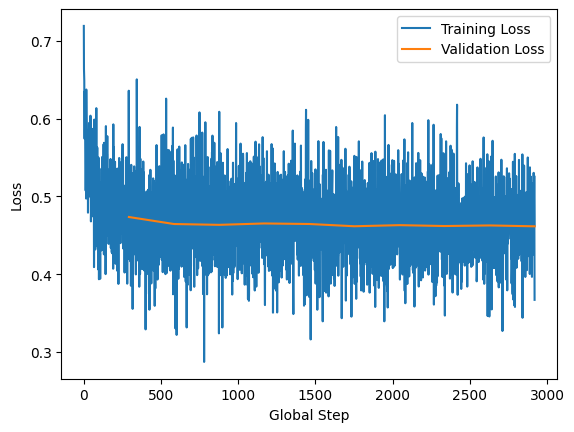

In [31]:
# Plot a loss curve
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses_steps, val_losses, label="Validation Loss")
plt.xlabel("Global Step")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Use the model to make predicions!
Evaluate the model based on predictions made with X_test $\rightarrow$ y_test

In [34]:
# Run predictions on the training and testing set
y_pred_test = model(X_test)
y_pred_train = model(X_train)

# Flatten off the singleton dimension on the predictions, labels, and weights
# and convert to numpy arrays
y_pred_test = y_pred_test.cpu().detach().numpy().flatten()
y_pred_train = y_pred_train.cpu().detach().numpy().flatten()
y_test = y_test.cpu().detach().numpy().flatten()
y_train = y_train.cpu().detach().numpy().flatten()
weights_test = weights_test.cpu().detach().numpy().flatten()
weights_train = weights_train.cpu().detach().numpy().flatten()

# Print the first few predictions and labels
with np.printoptions(precision=3, suppress=True, threshold=np.inf):
    print("y_pred_test: ", y_pred_test[:5])
    print("y_test: ", y_test[:5].flatten(), "\n")
    print("y_pred_train: ", y_pred_train[:5])
    print("y_train: ", y_train[:5].flatten(), "\n")

y_pred_test:  [0.754 0.    0.449 0.865 0.403]
y_test:  [0. 0. 1. 1. 1.] 

y_pred_train:  [0.767 0.468 0.375 0.617 0.401]
y_train:  [1. 1. 1. 0. 1.] 



### ROC curves and Area Under the Curve (AUC)

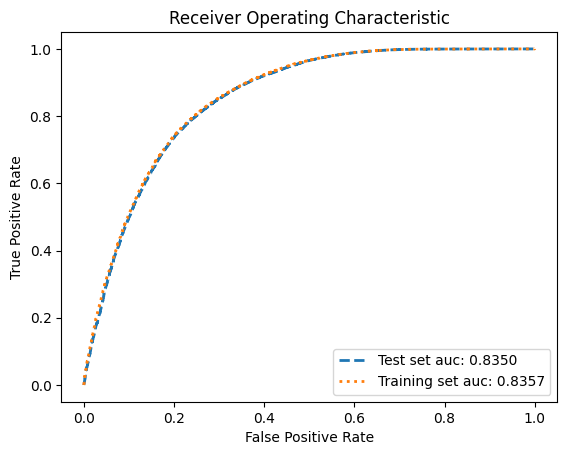

In [35]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

fpr_test, tpr_test, _ = roc_curve(y_true=y_test, y_score=y_pred_test, sample_weight=weights_test)
fpr_train, tpr_train, _ = roc_curve(y_true=y_train, y_score=y_pred_train, sample_weight=weights_train)
# Note I'm not using the weights here, "roc_auc_score" is an example of a function that can break with negative weights
auc_test = roc_auc_score(y_true=y_test, y_score=y_pred_test)
auc_train = roc_auc_score(y_true=y_train, y_score=y_pred_train)
plt.plot(fpr_test, tpr_test, color='tab:blue', lw=2, ls="--", label=f"Test set auc: {auc_test:.4f}")
plt.plot(fpr_train, tpr_train, color='tab:orange', lw=2, ls=":", label=f"Training set auc: {auc_train:.4f}")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

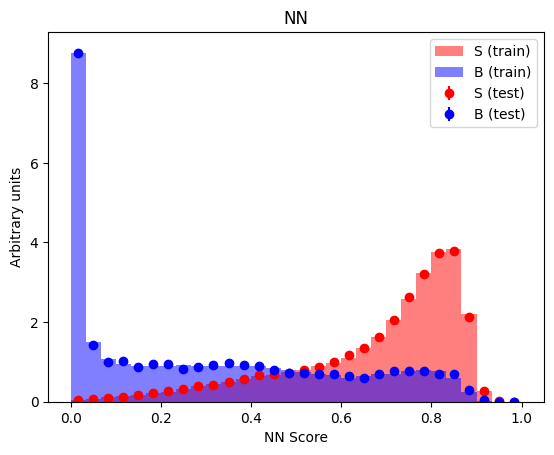

In [36]:
from extra_functions import compare_train_test

compare_train_test(
    y_pred_train,
    y_train.flatten(),
    y_pred_test,
    y_test.flatten(),
    xlabel="NN Score",
    title="NN",
    weights_train=weights_train,
    weights_test=weights_test,
)

## Significance Function

In a standard statistical analysis for a search, an observed significance is obtained. This corresponds to the significance with which we reject the background-only hypothesis. That is, the higher the significance, the more likely the signal we are searching for exists.

We can use the formula below to obtain an estimated value of the expected significance.

$Z = \sqrt{2+((s+b)\ln(1+s/b)-s)}$

**see [arXiv:1007.1727](https://arxiv.org/pdf/1007.1727.pdf) [Eq. 97]**

This corresponds to the signal sensitivity. This is a good indication of the performance of our classification model. => We want the significance to be as high as possible.



In [37]:
from math import sqrt
from math import log


def amsasimov(s, b):
    if b <= 0 or s <= 0:
        return 0
    try:
        return sqrt(2 * ((s + b) * log(1 + float(s) / b) - s))
    except ValueError:
        print(1 + float(s) / b)
        print(2 * ((s + b) * log(1 + float(s) / b) - s))

The simplest way to use the classifier score to separate signal and background is to make a cut on the classifier score for all the events. In the following, we scan through the cut value and look at the corresponding significance. This can help us determine the optimal cut value of the classifier score.

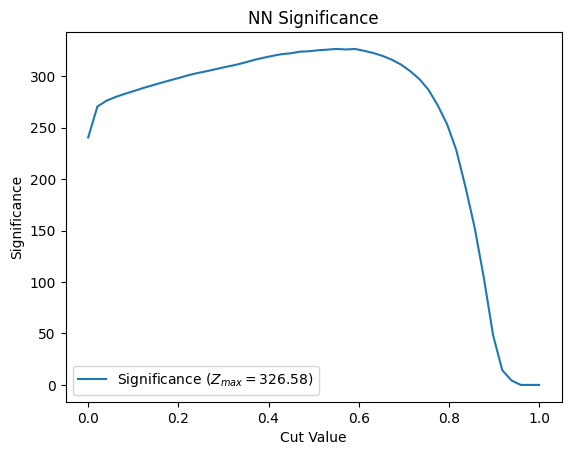

In [38]:
int_pred_test_sig = [weights_test[(y_test == 1) & (y_pred_test > th_cut)].sum() for th_cut in np.linspace(0, 1, num=50)]
int_pred_test_bkg = [weights_test[(y_test == 0) & (y_pred_test > th_cut)].sum() for th_cut in np.linspace(0, 1, num=50)]
vamsasimov = [amsasimov(sumsig, sumbkg) for (sumsig, sumbkg) in zip(int_pred_test_sig, int_pred_test_bkg)]
Z = max(vamsasimov)

plt.plot(np.linspace(0, 1, num=50), vamsasimov, label=f'Significance ($Z_{{max}} = {np.round(Z, decimals=2)}$)')
plt.title("NN Significance")
plt.xlabel("Cut Value")
plt.ylabel("Significance")
plt.legend()
plt.show()

## Avoiding boilerplate: Pytorch lightning

If you kept using "pure pytorch" in your own work, after some time you'd realize that you spend a lot of time writing the same lines of code over and over again.
The perfect example of this is the training loop.
It will look very similar for training almost any neural network.
This kind of code is called "boilerplate", and if you find youself writing a lot of it you're probably wasting time in the writing and inevitable debugging.
This is why there are packages that aim to abstract away large chunks of the code needed to train a neural network.
Tensorflow, for example, ships with a package called Keras that does this.
The JAX tools are less developed, but are getting better and better.
For pytorch, there is a package called PyTorch lightning.

Let's re-run training the network, but do it using lightning and see how much more efficient we can be.
Along the way, we'll also use some data utility classes that ship with PyTorch, and automate a lot of the data handling steps we had to implement ourselves above

In [39]:
import lightning as L

In [46]:
# Central to pytorch lightning is the "LightningModule" class which organizes steps in the training loop into reusable pieces
class HiggsNetLightning(L.LightningModule):
    def __init__(self, input_dim, means, stds):
        super().__init__()
        self.model = HiggsNet(input_dim=input_dim, means=means, stds=stds)
        self.criterion = torch.nn.BCELoss(reduction="none")

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y, weights = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        loss = (loss * weights).mean()
        self.log("train_loss", loss, prog_bar=True)  # Display the loss in the progress bar
        return loss

    def validation_step(self, batch, batch_idx):
        x, y, weights = batch
        y_hat = self(x)
        loss = self.criterion(y_hat, y)
        loss = (loss * weights).mean()
        self.log("val_loss", loss, prog_bar=True)  # Display the loss in the progress bar
        return loss
    
    def predict_step(self, batch, batch_idx):
        x, y, weights = batch
        y_hat = self(x)
        return y_hat

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=0.001)

In [47]:
model = HiggsNetLightning(input_dim=6, means=means, stds=stds)

If we're not going to write a training loop, what do we do with the data? Lightning expects the data to be wrapper in pytorch datasets and dataloaders, two classes that make training neural networks vastly easier.

In [48]:
# A tensor dataset is a simple class that wraps a tensor and provides a way to iterate over it
dataset = torch.utils.data.TensorDataset(data, target, weights)

# Datasets support splitting into training, validation, and test sets
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [0.5, 0.25, 0.25])

# Datasets can be used in a dataloader, which will automatically batch and shuffle the data
# We also don't need to use ".to(device)" here, as the dataloader will automatically move the data to the GPU
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1024, shuffle=True)  # Setting shuffle to True will shuffle the data every epoch
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=1024, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1024, shuffle=False)


In [49]:
# Some operations to get the data out of the dataset and dataloader classes
first_five_events = dataset[:5]  # This yields a tuple of tensors, in the order they were passed to the dataset
print(f"Data: {first_five_events[0].shape}")
print(f"Target: {first_five_events[1].shape}")
print(f"Weights: {first_five_events[2].shape}", "\n")

# To get data out of the dataloader, you can iterate over it, or if you want one batch, build an iterable and use the "next" function
first_batch = next(iter(train_loader))
print(f"Data: {first_batch[0].shape}")
print(f"Target: {first_batch[1].shape}")
print(f"Weights: {first_batch[2].shape}")

Data: torch.Size([5, 6])
Target: torch.Size([5, 1])
Weights: torch.Size([5, 1]) 

Data: torch.Size([1024, 6])
Target: torch.Size([1024, 1])
Weights: torch.Size([1024, 1])


In [50]:
# The last thing we need is the "Trainer" class, which handles the training, validation, and testing of the model
trainer = L.Trainer(max_epochs=10, accelerator="gpu", devices=1)

/global/common/software/m3246/conda/lbl-school/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /global/common/software/m3246/conda/lbl-school/lib/p ...
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [51]:
# Now we can run training with one line of code
# Note we also don't need to move the model to GPU, lightning does this for us
trainer.fit(model, train_loader, val_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type     | Params | Mode 
-----------------------------------------------
0 | model     | HiggsNet | 67.9 K | train
1 | criterion | BCELoss  | 0      | train
-----------------------------------------------
67.8 K    Trainable params
12        Non-trainable params
67.9 K    Total params
0.271     Total estimated model params size (MB)
9         Modules in train mode
0         Modules in eval mode


/global/common/software/m3246/conda/lbl-school/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.
/global/common/software/m3246/conda/lbl-school/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.


Epoch 9: 100%|██████████| 292/292 [00:05<00:00, 57.04it/s, v_num=1, train_loss=0.528, val_loss=0.468]

`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 292/292 [00:05<00:00, 56.92it/s, v_num=1, train_loss=0.528, val_loss=0.468]


In [54]:
# To run predictions, we can also use the trainer
predictions = trainer.predict(model, test_loader)

# Predictions are returned as a list of tensors, so we need to concatenate them
predictions = np.concatenate([p.cpu().detach().numpy().flatten() for p in predictions])

/global/common/software/m3246/conda/lbl-school/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /global/common/software/m3246/conda/lbl-school/lib/p ...
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/global/common/software/m3246/conda/lbl-school/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=255` in the `DataLoader` to improve performance.


Predicting DataLoader 0: 100%|██████████| 146/146 [00:01<00:00, 119.10it/s]


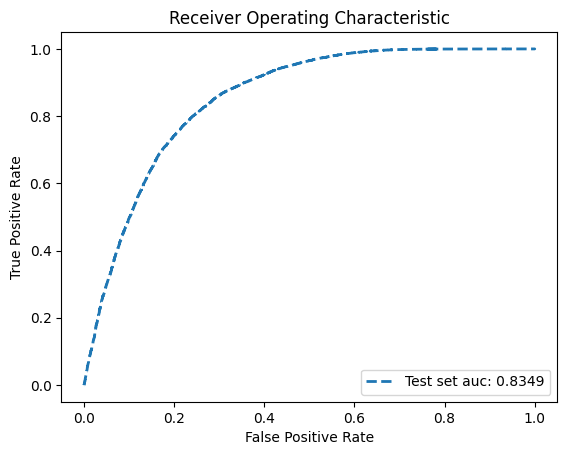

In [62]:
# Finally plot a ROC curve and calculate AUC
y_test = test_dataset[:][1].cpu().detach().numpy().flatten()
weights_test = test_dataset[:][2].cpu().detach().numpy().flatten()

fpr_test, tpr_test, _ = roc_curve(y_true=y_test, y_score=predictions, sample_weight=weights_test)
auc_test = roc_auc_score(y_true=y_test, y_score=predictions)
plt.plot(fpr_test, tpr_test, color='tab:blue', lw=2, ls="--", label=f"Test set auc: {auc_test:.4f}")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

As a final note, for simple tasks like this one using all of these classes might seem a little silly, it's not that much more work to just do it yourself.
However when you start to scale things to solve research problems, things can get complicated very quickly.
Some advanced topics that these packages will vastly simplify, at least in standard applications:

- Parallelized data loading: https://docs.pytorch.org/docs/stable/data.html
- Experiment tracking: https://wandb.ai/site/ or https://www.comet.com/site/
- Data parallel training: https://lightning.ai/docs/pytorch/stable/accelerators/gpu_intermediate.html
- Model parallel training (god mode): https://lightning.ai/docs/pytorch/stable/advanced/model_parallel/fsdp.html

In general, the more code you can offload onto someone else, the more time and frustration you'll save yourself.
Packages are very helpful, use them as much as possible!

Some exercises to try if there's time:

1. Try to get a higher AUC. Some ideas:
- Adjust learning rate
- Adjust the number of neurons, and layers
- Increase epochs
- Enable early stopping (and increase max epochs)
- Adjust batch size
- Change activations: [relu, leakyrelu, selu, tanh, gelu]
- Try different optimizers (e.g. AdamW, Ranger, Lion)
- Learning rate scheduler
- Use a more complicated structure? This data is "tabular", meaning we don't have variable length inputs, so maybe don't go there just yet
- More... google!

2. Break the model. Some ideas:
- Get it to overfit
- Don't standardize the inputs
- Use very unbalanced data
- Mess with the weights

3. Train a BDT instead
- Lightning fast to train, and very very good at simple tasks
- Would definitely cover this, if we had more time